# Bioinformatics mini project

Identify miRNAsite on lncRNA using deep neural network model

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import glob
import re
import random
import collections
import os
import sys
import json
import pickle

from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import GRU, Dropout, LSTM
from keras.models import load_model
from keras.layers import Embedding, Reshape, Activation, Input, Dense, Masking, Conv1D, MaxPooling1D, Bidirectional
from keras.layers.merge import Dot
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.utils.np_utils import to_categorical
from keras import backend as K
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint, CSVLogger, History

def load(name):
    try:
        with open(name, "rb") as f:
            data = pickle.load(f)
    except Exception as e:
        print(e)
        data = []
    return data

def save(obj,name):
    with open(name, "wb") as f:
        pickle.dump(obj, f, protocol=3)
    return

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Don't need to run this cell
data = load('starbase_crawl.pkl')

for i in range(len(data)):
    a, b, c, d = data[i]
    e = d.replace('ncRNA ','')
    data[i] = (a,b,c,e)

head = ("lncRNA:miRNA", "Target Location", "miRNA", "ncRNA")
df = pd.DataFrame(data = data, columns = head)
df.head()

,lncRNA:miRNA,Target Location,miRNA,ncRNA
0,CTA-204B4.6:hsa-miR-200b-3p,chr8:141537414-141537439[-],3'-agtaGTAATGG----TCCGTCATAAt-5',5'-gagaCACTGCCTCGTATTCAGTATTa-3'
1,CTD-2630F21.1:hsa-miR-200b-3p,chr19:36981279-36981298[+],3'-agTAGTAATGGTCCGTCATAAt-5',5'-gtATC-TCA-TGGCCAGTATTt-3'
2,CTB-92J24.2:hsa-miR-200b-3p,chr19:24111074-24111096[+],3'-agTAGTA-ATGGTCCGTCATAAt-5',5'-aaGTTATCCACTCTCCAGTATTc-3'
3,RP11-473I1.10:hsa-miR-200b-3p,chr16:9205929-9205951[+],3'-agtAG-TAATGGTCCGTCATAAt-5',5'-attTCAATAAAAATTCAGTATTa-3'
4,AC005154.5:hsa-miR-200b-3p,chr7:30617568-30617592[-],3'-agTAGTAATGGTCC---GTCATAAt-5',5'-gcAATAATACTTGGCCCCAGTATTg-3'


In [3]:
# Don't need to run this cell
database_file = open('lncipedia_3_1.fasta.txt','r')
database = []
name = ''
seq = ''
for line in database_file:
    if line[0] == '>':
        if name != '':
            database.append((name, seq))
            name = ''
            seq = ''
        name = line[1:].replace('\n','')
    else:
        seq += line.replace('\n','')

sb_head = ("name", "sequence")
starbase = pd.DataFrame(data = database, columns = sb_head)

starbase.head()

,name,sequence
0,lnc-C8orf56-1:8,AGAGGTGCCTCCCTTCCTTGAAACTTCTTCACCTTTGCTTCAAGAG...
1,lnc-PRYP4-3:1,TTCCAGTCAATGATTTTGGATTCCATTTTTTTGCATTCCATTACAT...
2,lnc-TTLL7-2:5,ACCGTTGCTCAGAGTCCAGGCCGGTTAGGACCAGAGCCTACCCCGG...
3,lnc-CLEC18B-3:5,GTAGATCATCATCATAACAGCTCCCAGTGAATCAATGCCTCCCTGC...
4,lnc-GPR119-1:1,TACTCTGGCCACCACGATCTTGGCAGCCCACACCTGATCAGGACCT...


In [2]:
starbase = load('data/starbase.pkl')
df = load('data/df.pkl')
starbaseMap = load('data/prep_data.pkl')

In [3]:
ncRNA = df['ncRNA']
starbaseSEQ = starbase['sequence']
starbaseName = starbase['name']

[0, 0, 0, 0, 0, 0, 0, 1187, 497, 373, 330, 327, 412, 445, 607, 634, 782, 939, 950, 1024, 721, 412, 260, 166, 86, 40, 11, 5, 2, 2, 0, 0, 0, 0, 0]


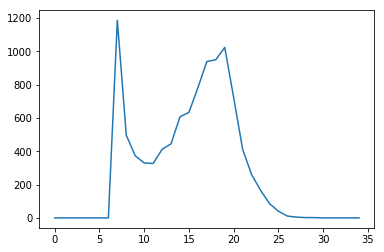

In [4]:
# miRNAsite length distibution
stat = [0]*35
for raw_rna in ncRNA:
    count = 0
    rna = raw_rna[2:-2].replace('-','')
    for c in rna:
        if c.upper() == c and c != '-':
            count += 1
    stat[count] +=1
print(stat)
plt.plot(stat)

[36897, 43989, 9828, 6716, 5059, 3004, 1827, 1348, 789, 590, 413, 270, 194, 156, 113, 73, 68, 58, 32, 258]


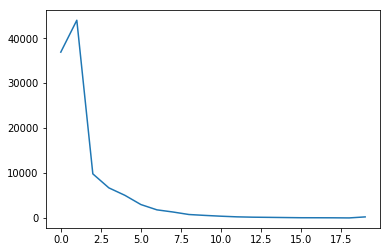

In [5]:
# lncRNA length distibution (<500, <1000, <1500 ... >10000)
stat = [0]*20
for rna in starbaseSEQ:
    stat[min(len(rna)//500,19)] +=1
print(stat)
plt.plot(stat)

In [6]:
CHARS = ['A','T','C','G','N','P']
CHARS_MAP = {v: k for k, v in enumerate(CHARS)}
char = np.array(CHARS)
classes = {'0':0, '1': 1}
window_size = 500

## New 

In [6]:
datasets = []

for i in range(len(starbaseMap)):
    bind_site, full_seqs = starbaseMap[i]
    bind_site_raw = ncRNA[i][2:-2].replace('-','')
    shift = 0
    end = 0
    while bind_site_raw[shift].upper() != bind_site_raw[shift]:
        shift += 1
        if shift >= len(bind_site_raw):
            break
    end += shift
    if end < len(bind_site_raw):
        while bind_site_raw[end].upper() == bind_site_raw[end]:
            end += 1
            if end >= len(bind_site_raw):
                break
    else:
        end = end
    full_seq_index = [int(e) for e in full_seqs.split()]
    for index in full_seq_index:
        seq = starbaseSEQ[index]
        start = seq.index(bind_site)+shift
        stop = start+end-shift
        long = stop-start
        
        if len(seq) <= window_size:
            seq_list = []
            label = []
            for s in seq:
                seq_list.append(CHARS_MAP[s])
            while len(seq_list) < window_size:
                seq_list.append(CHARS_MAP['P'])
            for i in range(len(seq)):
                if i >= start and i < stop:
                    label.append(1)
                else:
                    label.append(0)
            while len(label) < window_size:
                label.append(0)
            datasets.append([seq_list, label])
        
print('datasets:',len(datasets))

datasets: 16736


In [7]:
save(datasets,'data/datasets-new-500-p.pkl')

In [8]:
# How datasets look like?
# Padding = 5
print(datasets[57])

[[0, 1, 1, 0, 3, 1, 0, 1, 1, 0, 2, 1, 0, 2, 1, 3, 3, 3, 2, 1, 2, 2, 0, 0, 3, 1, 1, 2, 2, 1, 2, 0, 1, 2, 1, 3, 0, 0, 0, 1, 2, 1, 3, 1, 2, 1, 2, 2, 1, 2, 1, 3, 3, 0, 0, 0, 1, 0, 2, 1, 1, 0, 1, 1, 1, 0, 2, 0, 0, 3, 0, 2, 3, 0, 2, 3, 1, 1, 1, 2, 1, 1, 3, 1, 2, 0, 2, 0, 0, 2, 3, 2, 0, 3, 3, 1, 1, 1, 0, 0, 0, 2, 0, 3, 2, 0, 3, 2, 1, 1, 1, 1, 0, 0, 0, 1, 3, 1, 1, 1, 0, 2, 1, 3, 1, 3, 3, 3, 0, 0, 3, 0, 0, 1, 0, 3, 1, 2, 0, 0, 3, 3, 3, 0, 3, 1, 3, 3, 1, 3, 2, 3, 1, 1, 3, 3, 3, 0, 0, 3, 0, 2, 0, 3, 0, 2, 2, 0, 3, 0, 3, 1, 1, 1, 3, 2, 1, 3, 2, 1, 3, 3, 2, 0, 2, 1, 3, 1, 1, 0, 2, 3, 2, 0, 3, 3, 3, 0, 2, 1, 3, 1, 1, 1, 3, 3, 2, 0, 1, 3, 0, 2, 2, 1, 1, 2, 0, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 3, 3, 1, 1, 2, 1, 1, 1, 3, 3, 1, 2, 1, 1, 1, 2, 1, 0, 0, 3, 3, 1, 3, 3, 2, 2, 1, 2, 0, 0, 1, 1, 1, 2, 1, 1, 1, 0, 1, 2, 0, 3, 1, 0, 0, 0, 1, 0, 0, 3, 0, 1, 1, 0, 1, 2, 1, 2, 1, 3, 0, 3, 0, 1, 3, 1, 2, 0, 1, 1, 2, 0, 2, 1, 2, 0, 0, 0, 1, 0, 3, 2, 2, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 2, 1, 0, 2, 1, 1, 3, 2, 0, 1,

In [9]:
def prepare_dataset(datasets):
    input_text = list()
    for context, label in datasets:    
        indexed_text = context[:window_size]
        input_text.append([indexed_text,label]) 
    random.shuffle(input_text)
    return input_text

input_data = prepare_dataset(datasets)
train_data = input_data[:int(len(input_data)*0.6)]
test_data = input_data[int(len(input_data)*0.6):int(len(input_data)*0.8)]
val_data = input_data[int(len(input_data)*0.8):]

del input_data

train_input = [data[0] for data in train_data]
train_target = [data[1] for data in train_data]

del train_data

test_input = [data[0] for data in test_data]
test_target = [data[1] for data in test_data]

del test_data

val_input = [data[0] for data in val_data]
val_target = [data[1] for data in val_data]

del val_data

train_input = np.array(train_input)
test_input = np.array(test_input)
val_input = np.array(val_input)

train_target = np.array(train_target)
test_target = np.array(test_target)
val_target = np.array(val_target)

In [3]:
uses = '500-p.pkl'

In [11]:
save(train_input,'data/train_input-' + uses)
save(test_input,'data/test_input-' + uses)
save(val_input,'data/val_input-' + uses)
save(train_target,'data/train_target-' + uses)
save(test_target,'data/test_target-' + uses)
save(val_target,'data/val_target-' + uses)

In [4]:
train_input = load('data/train_input-' + uses)
test_input = load('data/test_input-' + uses)
val_input = load('data/val_input-' + uses)
train_target = load('data/train_target-' + uses)
test_target = load('data/test_target-' + uses)
val_target = load('data/val_target-' + uses)

In [15]:
# Embedding 50 dim
# Conv1D 1000 filters with 20 kernel_size
# Bi-GRU 2 layer with 1000 unit (each-layer)
# Dropout 20% every layer
def get_model():
    cls_model = Sequential()
    cls_model.add(Embedding(len(CHARS), 50, input_length=window_size))
    cls_model.add(Dropout(0.2))
    cls_model.add(Conv1D(1000, 20, activation='relu'))
    cls_model.add(Dropout(0.2))
    cls_model.add(Bidirectional(GRU(500, return_sequences=True)))
    cls_model.add(Dropout(0.2))
    cls_model.add(Bidirectional(GRU(500)))
    cls_model.add(Dropout(0.2))
    cls_model.add(Dense(window_size, activation='sigmoid'))
    cls_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    cls_model.summary()
    return cls_model

In [16]:
# Set the name of model (version)
hype = '-j'

In [10]:
filepath = 'stat/weights' + hype + '.h5'
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min')
csv_logger = CSVLogger('stat/training_history' + hype + '.csv')
history = History()

callbacks_list = [checkpoint, history, csv_logger]
cls_model = get_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 50)           300       
_________________________________________________________________
dropout_5 (Dropout)          (None, 500, 50)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 481, 1000)         1001000   
_________________________________________________________________
dropout_6 (Dropout)          (None, 481, 1000)         0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 481, 1000)         4503000   
_________________________________________________________________
dropout_7 (Dropout)          (None, 481, 1000)         0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 1000)              4503000   
__________

In [11]:
cls_model.fit(train_input,
              train_target,
              batch_size = 32,
              epochs = 30,
              verbose = 1,
              callbacks = callbacks_list,
              validation_data = [val_input, val_target]
)

Train on 10041 samples, validate on 3348 samples
Epoch 1/30
10041/10041 [==============================] - 940s - loss: 0.1100 - acc: 0.9754 - val_loss: 0.0909 - val_acc: 0.9793
Epoch 2/30
10041/10041 [==============================] - 944s - loss: 0.0822 - acc: 0.9787 - val_loss: 0.0697 - val_acc: 0.9815
Epoch 3/30
10041/10041 [==============================] - 944s - loss: 0.0711 - acc: 0.9803 - val_loss: 0.0633 - val_acc: 0.9822
Epoch 4/30
10041/10041 [==============================] - 936s - loss: 0.0588 - acc: 0.9824 - val_loss: 0.0537 - val_acc: 0.9838
Epoch 5/30
10041/10041 [==============================] - 939s - loss: 0.0568 - acc: 0.9812 - val_loss: 0.0490 - val_acc: 0.9848
Epoch 6/30
10041/10041 [==============================] - 947s - loss: 0.0462 - acc: 0.9842 - val_loss: 0.0447 - val_acc: 0.9858
Epoch 7/30
10041/10041 [==============================] - 951s - loss: 0.0401 - acc: 0.9858 - val_loss: 0.0432 - val_acc: 0.9862
Epoch 8/30
10041/10041 [========================

KeyboardInterrupt: 

In [12]:
# Incase you want to save the latest model no matter what
cls_model.save_weights('stat/weights'+hype+'-full.h5')

In [19]:
cls_model = get_model()
cls_model.load_weights('stat/weights'+hype+'.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 50)           300       
_________________________________________________________________
dropout_9 (Dropout)          (None, 500, 50)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 481, 1000)         1001000   
_________________________________________________________________
dropout_10 (Dropout)         (None, 481, 1000)         0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 481, 1000)         4503000   
_________________________________________________________________
dropout_11 (Dropout)         (None, 481, 1000)         0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 1000)              4503000   
__________

In [17]:
def evaluate(x_test, y_test, model):
    y_pred = model.predict(x_test)
    
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0

    one_correct = 0
    zero_correct = 0
    wrong = 0
    miss = 0
    for i in range(len(x_test)):
        for j in range(len(y_pred[i])):
            if y_test[i][j] == 1 and y_pred[i][j] == 1:
                one_correct += 1
            elif y_test[i][j] == 0 and y_pred[i][j] == 1:
                wrong += 1
            elif y_test[i][j] == 1 and y_pred[i][j] == 0:
                miss += 1
            elif y_test[i][j] == 0 and y_pred[i][j] == 0:
                zero_correct += 1

    return one_correct, zero_correct, wrong, miss
    
one_correct, zero_correct, wrong, miss = evaluate(test_input, test_target, cls_model)
precision = one_correct/(one_correct+wrong)
recall = one_correct/(one_correct+miss)
print("Correct (1):", one_correct)
print("Correct (0):", zero_correct)
print("Wrong (0->1):", wrong)
print("Miss (1->0):", miss)
print("Recall:", recall)
print("Precision:", precision)
print("F-score:", 2*(recall*precision)/(recall+precision))
print("Accuracy:", (one_correct+zero_correct)/(one_correct+zero_correct+wrong+miss))

Correct (1): 25884
Correct (0): 1628885
Wrong (0->1): 8651
Miss (1->0): 10080
Recall: 0.7197197197197197
Precision: 0.7495005067323006
F-score: 0.7343082880608237
Accuracy: 0.9888072901105468


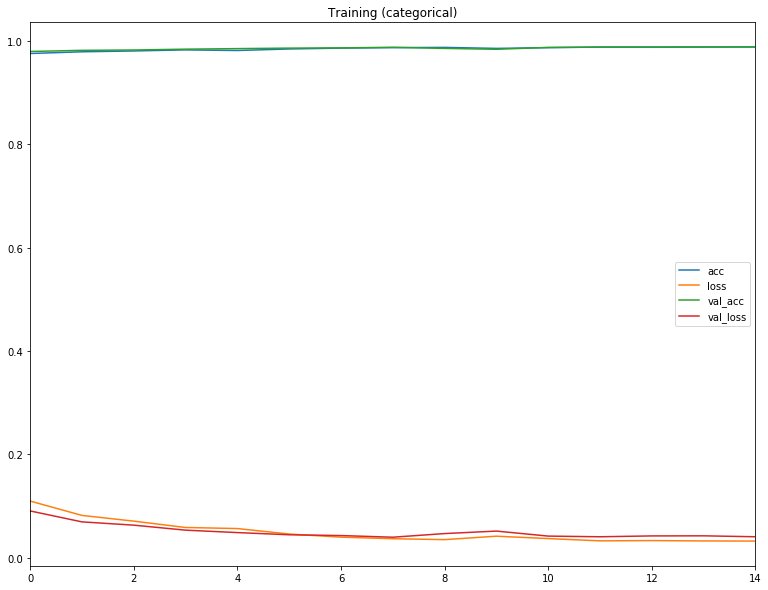

In [18]:
hist = pd.read_csv('stat/training_history'+hype+'.csv')
hist = hist.drop('epoch', axis=1)
plt.figure(figsize=(13,10))
hist.plot(figsize=(13,10))
plt.title('Training (categorical)')

## Use model to predict

In [ ]:
# Read fasta format
test_inf = open('data/test_set.fa')
bases_test = []
named = []
catch = ''
for t in test_inf:
    if t[0] == '>':
        named.append(t)
        if len(catch) > 0:
            bases_test.append(catch)
            catch = ''
    else:
        catch += t.replace('\n','')

bases_test.append(catch)  

# Pad
test_set = []
for i in range(len(bases_test)):
    while len(bases_test[i]) < 500:
        bases_test[i] += 'P'

test_set_raw = []
named_raw = []
for i in range(len(bases_test)):
    t = bases_test[i]
    if len(t) > 500:
        continue
    emb = []
    for alpha in t:
        emb.append(CHARS_MAP[alpha])
    test_set.append(emb)
    test_set_raw.append(t)
    named_raw.append(named[i])
test_set = np.array(test_set)

In [ ]:
# Embedding 50 dim
# Conv1D 1000 filters with 20 kernel_size
# Bi-GRU 2 layer with 1000 unit (each-layer)
# Dropout 20% every layer
def get_model():
    cls_model = Sequential()
    cls_model.add(Embedding(len(CHARS), 50, input_length=window_size))
    cls_model.add(Dropout(0.2))
    cls_model.add(Conv1D(1000, 20, activation='relu'))
    cls_model.add(Dropout(0.2))
    cls_model.add(Bidirectional(GRU(500, return_sequences=True)))
    cls_model.add(Dropout(0.2))
    cls_model.add(Bidirectional(GRU(500)))
    cls_model.add(Dropout(0.2))
    cls_model.add(Dense(window_size, activation='sigmoid'))
    cls_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    cls_model.summary()
    return cls_model

def single_predict(x_test, model):
    y_pred = model.predict(np.array([x_test]))
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0
    return np.array([int(e) for e in y_pred[0]])

def single_predict_keep_prob(x_test, model):
    y_pred = model.predict(np.array([x_test]))
    return y_pred[0]

cls_model = get_model()
cls_model.load_weights('stat/weights'+hype+'.h5')

In [ ]:
test_result = []
for i in range(len(test_set)):
    pred = single_predict(test_set[i], cls_model)
    test_result.append(pred)
    
done = []
for i in range(len(test_result)):
    site = ''
    cap = ''
    first = -1
    for j in range(len(test_result[i])):
        if test_set_raw[i][j] == 'P':
            break
        if test_result[i][j] == 1:
            if first == -1:
                first = j
            site += test_set_raw[i][j].upper()
            cap += test_set_raw[i][j].upper()
        else:
            site += test_set_raw[i][j].lower()
    if len(cap) == 0:
        cap = '-'
    done.append([named[i].replace('\n','')[1:],site,cap,first])

import csv

# Write CSV file
with open('predict-for-below-500.csv', 'w') as fp:
    fp.write('\ufeff')
    writer = csv.writer(fp, delimiter=',')
    writer.writerow(["name", "full_seq", "miRNAsite", "start_index"])  # write header
    writer.writerows(done)